In [1]:
from qiskit.circuit.library import SwapGate
from scipy.sparse import csr_matrix, kron
from qiskit.quantum_info.operators import Operator
import numpy as np 
from process_operator import * 
from measure_model import * 
from figure import * 
from qiskit.circuit.library import XXPlusYYGate, CPhaseGate 
from exact import H_exact
import matplotlib.pyplot as plt
from numerical_krylov import numerical_quantum_krylov_diag
from statevector_sim import statevector_circuit

#### DEFINE BASIC OPERATORS #####
cnot = csr_matrix(np.array([[1,0,0,0],[0,0,0,1],[0,0,1,0],[0,1,0,0]]))
swap = csr_matrix(Operator(SwapGate()).data)
Id_8 = []
for i in range(8):
    Id_8.append(csr_matrix(np.eye(2**i)))
cx_0_8 = csr_matrix(np.eye(2**9))
for i in range(7):
    I1 = Id_8[i]
    I2 = Id_8[7-i]
    swap_net = kron(kron(I2,swap),I1)
    cx_0_8 = swap_net @ cx_0_8
cx_0_8 = kron(cnot, Id_8[7]) @ cx_0_8
for i in range(7):
    I1 = Id_8[i+1]
    I2 = Id_8[7-(i+1)]
    swap_net = kron(kron(I1,swap),I2)
    cx_0_8 = swap_net @ cx_0_8

(0.5, 10.5)

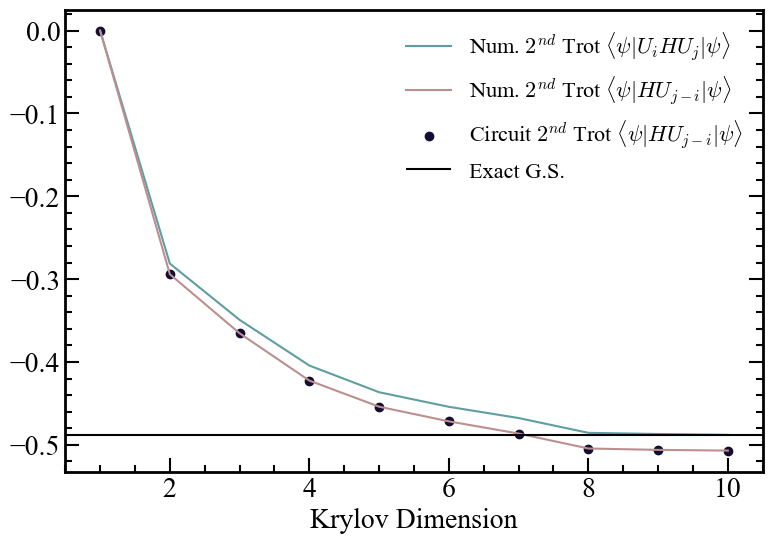

In [2]:
######### TESTING: QUANTUM CIRCUIT CASE FOR HALF FILLING CONDITION ######### 
######### exact and numerical-trotter simulation #########
n, t, U, n_occ, dt, krylov_d =  8, 1, 4, 4, 0.15, 10
exact_ground_state = H_exact(n, t, U, n_occ, True)
num_krylov, num_H, num_S= numerical_quantum_krylov_diag(n, '01010101', t, U, n_occ, dt, krylov_d, False)
num_krylov_toeplitz, num_H_toe, num_S_toe  = numerical_quantum_krylov_diag(n, '01010101', t, U, n_occ, dt, krylov_d, True)
######### statevector simulation of quantum circuit #########
state = np.zeros(shape=(2**9,1))
state[0] = 1
state = csr_matrix(state)
had_layer = kron(Id_8[4],kron(Id_8[4], H))
state = get_cx(0,False) @ (had_layer @ state)
state = cx_0_8 @ state 
state = (get_cx(7,False) @ (get_cx(7,True) @ state))
### layer 2 ### 
state = get_cx(2,True) @ (get_cx(2,False) @ (get_cx(1,False) @ state))
state = get_cx(5,False) @ (get_cx(5,True) @ (get_cx(6,True) @ state))

circuit_result, circuit_H, circuit_S = statevector_circuit(n, state, t, U, dt, krylov_d)
fig, ax = plt.subplots(figsize=(9,6))
plt.rcParams['mathtext.fontset'] ='cm'
ax.plot(np.arange(1,krylov_d+1,1),np.array(num_krylov)/(n_occ), color = 'cadetblue',
         label='Num. $2^{nd}$ Trot $\langle \psi|U_i H U_j|\psi \\rangle $')
ax.plot(np.arange(1,krylov_d+1,1), np.array(num_krylov_toeplitz)/(n_occ), color = 'rosybrown',
        label= 'Num. $2^{nd}$ Trot $\langle \psi| H U_{j-i}|\psi \\rangle $' )
ax.scatter(np.arange(1,krylov_d+1,1), np.array(circuit_result)/(n_occ), color = colors[0], label=
        'Circuit $2^{nd}$ Trot $\langle \psi| H U_{j-i}|\psi \\rangle $')
ax.hlines(exact_ground_state[0]/(n_occ), -0.05,krylov_d+1,'black', label='Exact G.S.')
adjust_ax(ax)
ax.legend(prop=font3, ncol=1, frameon=False)
ax.set_xlabel('Krylov Dimension', font=font2)
ax.set_xlim(0.5,krylov_d+0.5)


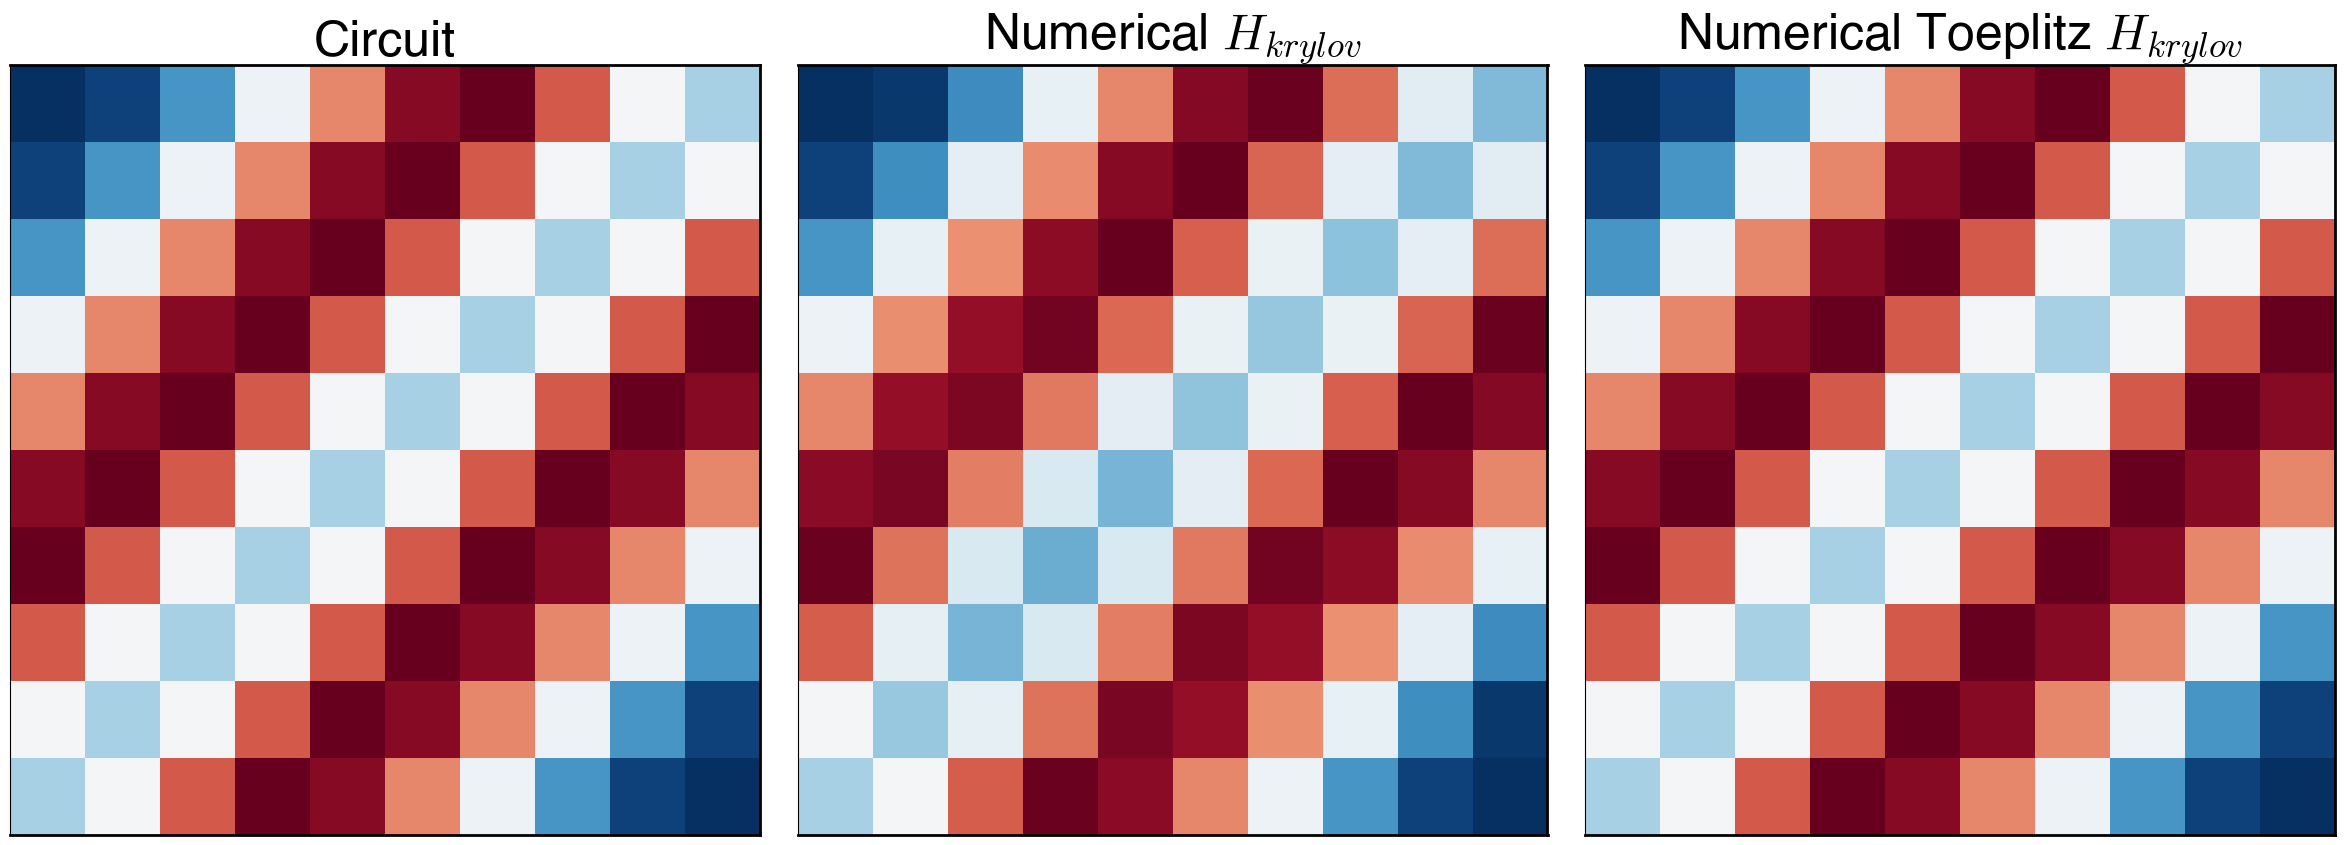

In [3]:
def adjust_ax_heatmap(ax):
    ax.tick_params(axis='x', labelsize =18, direction='out', length=6, width=1, )
    ax.tick_params(axis='y', labelsize =18, direction='out', length=6, width=1, )
    labels = ax.get_yticklabels() + ax.get_xticklabels() 
    [label.set_fontname('helvetica') for label in labels]
    [label.set_weight('normal') for label in labels]
    ax.spines["top"].set_linewidth(2)
    ax.spines["bottom"].set_linewidth(2)
    ax.spines["right"].set_linewidth(2)
fig, axes = plt.subplots(1,3, figsize=(30,10))
ax1, ax2, ax3 = axes[0], axes[1], axes[2]
y, x = np.meshgrid(np.arange(krylov_d), np.arange(krylov_d))
p1= ax1.pcolormesh(x,y, np.real(circuit_H), cmap='RdBu', vmin = np.min(np.real(circuit_H)), vmax=np.max(np.real(circuit_H)))
p2= ax2.pcolormesh(x,y, np.real(num_H), cmap='RdBu', vmin = np.min(np.real(num_H)), vmax=np.max(np.real(num_H)))
p3= ax3.pcolormesh(x,y, np.real(num_H_toe), cmap='RdBu', vmin = np.min(np.real(num_H_toe)), vmax=np.max(np.real(num_H_toe)))
ax1.set_xticks([]),ax2.set_xticks([]),ax3.set_xticks([])
ax1.set_yticks([]),ax2.set_yticks([]),ax3.set_yticks([])
plt.subplots_adjust(hspace=.0)
adjust_ax_heatmap(ax1), adjust_ax_heatmap(ax2), adjust_ax_heatmap(ax3)
font= {'family': 'helvetica','weight': 'normal','size': 36}
ax1.set_title('Circuit', font = font)
ax2.set_title('Numerical $H_{krylov}$', font = font)
ax3.set_title('Numerical Toeplitz $H_{krylov}$', font = font)
# cbar = fig.colorbar(p3, ax=ax3)
# cbar.ax.tick_params(labelsize=20)
# labels = cbar.ax.get_yticklabels() +  cbar.ax.get_xticklabels() 
# [label.set_fontname('helvetica') for label in labels]
# [label.set_weight('normal') for label in labels]
plt.subplots_adjust(wspace= 0.05)